# Dynamic Programming for Stereo Matching

## Overview

Dynamic Programming (DP) is a method used in stereo vision to compute disparity maps by finding the optimal pixel correspondences between a left and a right image scanline. This approach minimizes the cumulative matching cost, considering both pixel intensity differences and penalties for occlusions.

## Problem Setup

Given two scanlines:

- `Il`: Left image scanline
- `Ir`: Right image scanline

The goal is to compute the disparity map by aligning these scanlines optimally. The cost of aligning pixel `i` from `Il` with pixel `j` from `Ir` is given by:

\[
d_{ij} = \frac{(Il(i) - Ir(j))^2}{\sigma^2}
\]

Where:

- \( Il(i) \) and \( Ir(j) \) are the pixel intensities at positions `i` and `j` in the left and right images, respectively.
- \( \sigma \) is a constant representing pixel noise.

## Dynamic Programming Approach

### 1. Define the Cost Matrix

Let \( D(i, j) \) represent the minimum cumulative cost to align the first `i` pixels of `Il` with the first `j` pixels of `Ir`. The recurrence relation is:

\[
D(i, j) = \min \begin{cases} 
D(i-1, j-1) + d_{ij} & \text{(match)} \\
D(i-1, j) + c_0 & \text{(skip in Ir)} \\
D(i, j-1) + c_0 & \text{(skip in Il)}
\end{cases}
\]

Where:

- \( D(i-1, j-1) + d_{ij} \): Aligns pixels `i` and `j`.
- \( D(i-1, j) + c_0 \): Skips pixel `j` in `Ir`.
- \( D(i, j-1) + c_0 \): Skips pixel `i` in `Il`.
- \( c_0 \): Constant penalty for skipping a pixel.

### 2. Initialize the Matrix

Set the initial conditions:

\[
D(0, 0) = 0
\]

For boundary conditions:

\[
D(i, 0) = D(i-1, 0) + c_0 \quad \text{for} \quad i = 1, 2, \dots, N
\]

\[
D(0, j) = D(0, j-1) + c_0 \quad \text{for} \quad j = 1, 2, \dots, N
\]

### 3. Fill the Cost Matrix

Iterate through the matrix to compute the minimum costs:

```python
for i in range(1, N):
    for j in range(1, N):
        D[i, j] = min(
            D[i-1, j-1] + d_ij,
            D[i-1, j] + c0,
            D[i, j-1] + c0
        )


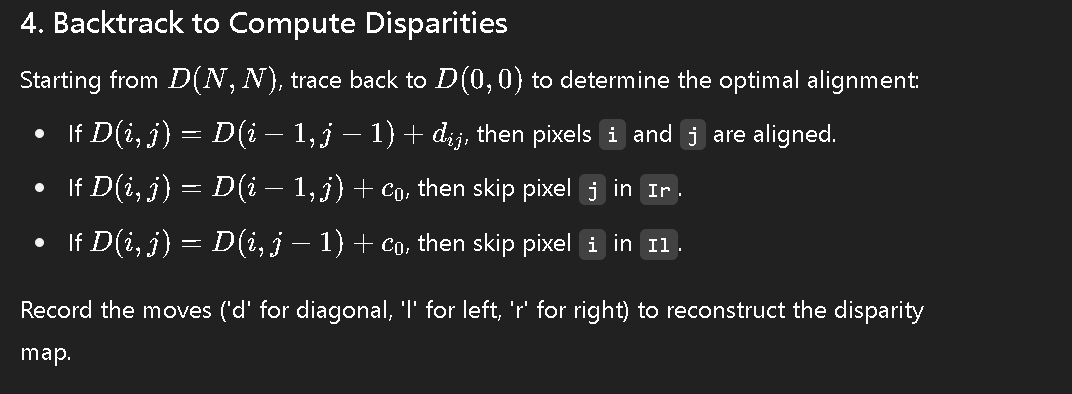

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def compute_disparity_dp(left_image, right_image, sigma=2, c0=1):
    h, w = left_image.shape
    left_disp_map = np.zeros_like(left_image, dtype=np.float32)
    right_disp_map = np.zeros_like(right_image, dtype=np.float32)

    for row in range(h):
        left_image_row = left_image[row].astype(np.float32) # arrays to store disparity maps. float 32 for precision
        right_image_row = right_image[row].astype(np.float32)
        N = len(left_image_row)  # Width of the image row, this should be equal to 'w'
        D = np.zeros((N, N), dtype=np.float32) #the cost matrix

        # Cost matrix initialization
        for i in range(N):
            for j in range(N):
                dij = ((left_image_row[i] - right_image_row[j]) ** 2) / (sigma ** 2)
                if i == 0 and j == 0:
                    D[i, j] = dij
                elif i == 0:
                    D[i, j] = D[i, j-1] + c0
                elif j == 0:
                    D[i, j] = D[i-1, j] + c0
                else:
                    D[i, j] = min(
                        D[i-1, j-1] + dij,
                        D[i-1, j] + c0,
                        D[i, j-1] + c0
                    )

        # Backtracking to compute disparity maps and track the path
        i, j = N - 1, N - 1
        moves = []  # To store the moves ('d', 'l', 'r')

        while i > 0 and j > 0:
            cost = D[i, j]
            dij = ((left_image_row[i] - right_image_row[j]) ** 2) / (sigma ** 2)
            if cost == D[i-1, j-1] + dij:
                disp = abs(i - j)
                left_disp_map[row, i] = disp
                right_disp_map[row, j] = disp
                moves.append('d')  # Diagonal move (match)
                i -= 1
                j -= 1
            elif cost == D[i-1, j] + c0:
                moves.append('l')  # vertical move (skip in left image)
                i -= 1
            else:
                moves.append('r')  # horizontal move (skip in right image)
                j -= 1

        # Reverse the moves to make it start from (1,1) (ana 3akast graph !!!!)
        moves.reverse()

    return left_disp_map, right_disp_map, D, moves


In [28]:
def plot_traceback(moves, ax):
    """
    Plot the traceback path based on the moves list.
    'd' = diagonal (match), 'l' = left (skip down), 'r' = right (skip right)
    Starts from (1, 1) and plots the movement path on the provided axes.
    """
    # Starting point at (1, 1)
    i, j = 1, 1
    x_vals, y_vals = [j], [i]  # Store the coordinates for plotting

    for move in moves:
        if move == 'd':  # Diagonal move (match)
            i += 1
            j += 1
        elif move == 'l':  # Left move (skip down)
            j += 1
        elif move == 'r':  # Right move (skip right)
            i += 1
        
        x_vals.append(j)
        y_vals.append(i)

    ax.plot(x_vals, y_vals, color='b', linestyle='-', linewidth=2)  # Plot the path as a line

    ax.set_xlabel('Right Image Pixel Values (j)')
    ax.set_ylabel('Left Image Pixel Values (i)')
    ax.set_title('Traceback Path')
    ax.set_aspect('equal', adjustable='box')
    ax.axis('on')  # Turn off axis for a cleaner plot

In [29]:

def read_images_from_folder(folder_path):
    images = []
    filenames = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
    print(filenames)
    
    for filename in filenames:
        image = cv2.imread(os.path.join(folder_path, filename))
        if image is not None:
            # Convert to grayscale
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            images.append(image_gray)
    return images


def process_images(folder_path):
    images = read_images_from_folder(folder_path)
    
    if len(images) % 2 != 0:
        print("Please make sure the folder contains an even number of images (left-right pairs).")
        return

    # Split images into left and right image groups
    left_images = images[:len(images)//2]   # First half are left images
    right_images = images[len(images)//2:]  # Second half are right images
    
    for i in range(len(left_images)):
        lI = left_images[i]      # Left image
        rI = right_images[i]     # Right image
        
        # Resize both images to match each other if necessary
        if lI.shape != rI.shape:
            print("Resizing right image to match the left image's dimensions.")
            rI = cv2.resize(rI, (lI.shape[1], lI.shape[0]))  # Resize to match left image size
            
        # Resize both images to downscaled resolution (using a smaller factor)
        lI_resized = cv2.resize(lI, (0, 0), fx=1, fy=1)
        rI_resized = cv2.resize(rI, (0, 0), fx=1, fy=1)
        
        # Apply Gaussian smoothing (blurring) with a smaller kernel to preserve details
        lI_smoothed = cv2.GaussianBlur(lI_resized, (3, 3), 0)
        rI_smoothed = cv2.GaussianBlur(rI_resized, (3, 3), 0)

        # Compute disparity using dynamic programming on smoothed images
        dp_left_disp_map, dp_right_disp_map, D_matrix, moves = compute_disparity_dp(lI_smoothed, rI_smoothed)
        normalized_disparity = cv2.normalize(dp_left_disp_map, None, 0, 255, cv2.NORM_MINMAX)

        # Create a figure with 2 rows and 2 columns: left image, right image, disparity map, and traceback
        plt.figure(figsize=(15, 10))

        # Plot the left image
        plt.subplot(2, 2, 1)
        plt.imshow(lI_resized, cmap='gray')
        plt.title(f"Left Image {i+1}")
        plt.axis('off')

        # Plot the right image
        plt.subplot(2, 2, 2)
        plt.imshow(rI_resized, cmap='gray')
        plt.title(f"Right Image {i+1}")
        plt.axis('off')

        # Plot the disparity map
        plt.subplot(2, 2, 3)
        plt.imshow(normalized_disparity.astype(np.uint8), cmap='jet')
        plt.colorbar(label='Disparity')
        plt.title("DP Disparity Map")
        plt.axis('off')

        # Plot the traceback path in a separate row
        ax = plt.subplot(2, 2, 4)  # Create a new subplot for the traceback path
        plot_traceback(moves, ax)
        
        # Show the plot with tight layout
        plt.tight_layout()  # Ensure no overlapping of subplots
        plt.show()





['l1.png', 'l2.png', 'l3.png', 'r1.png', 'r2.png', 'r3.png']


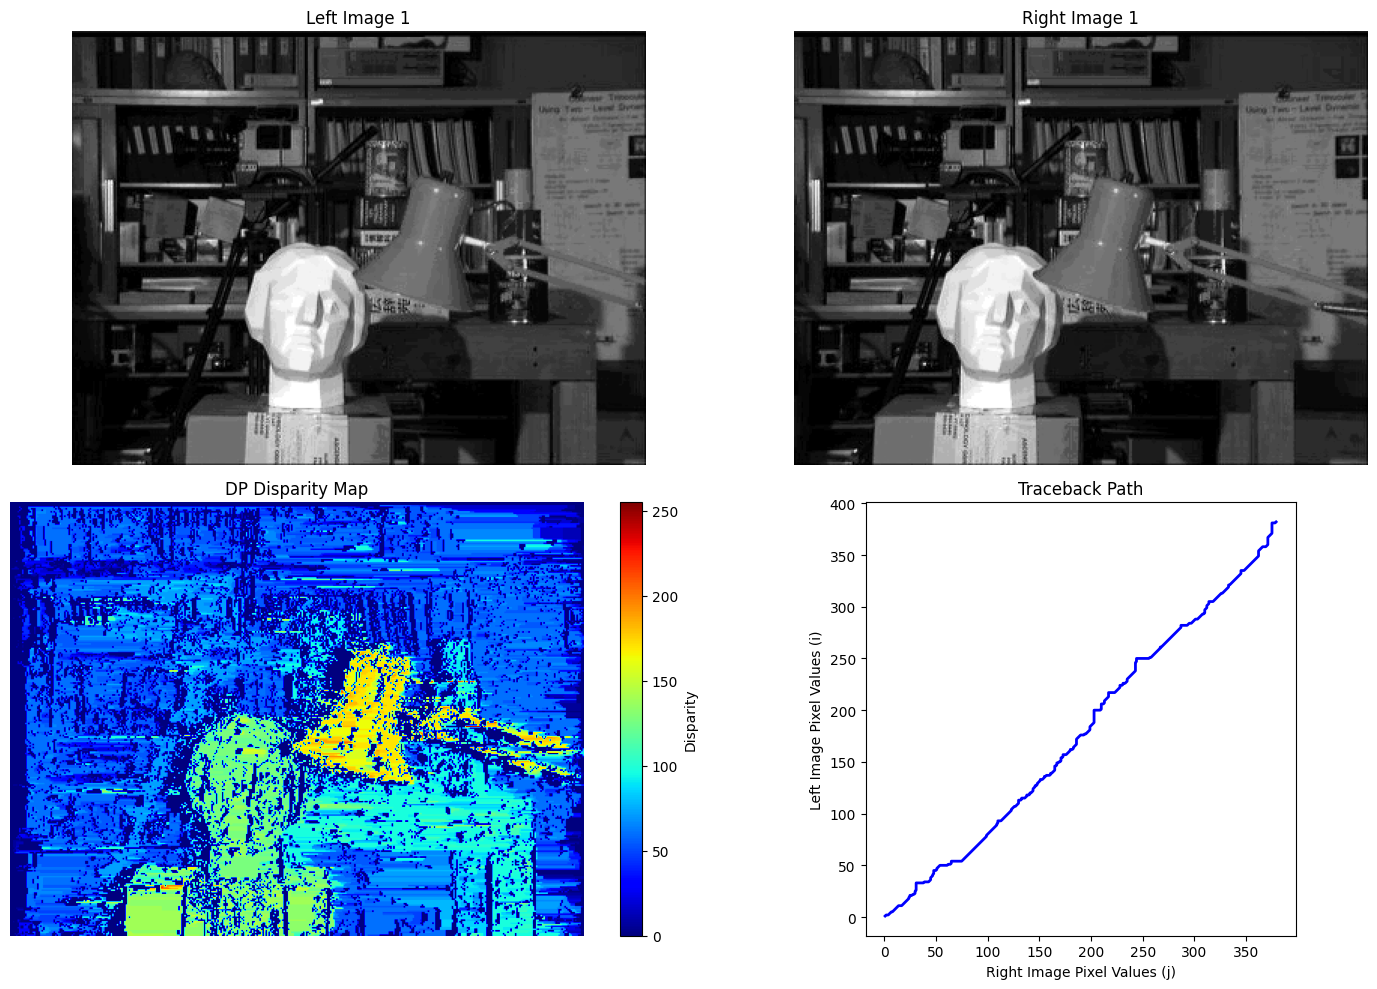

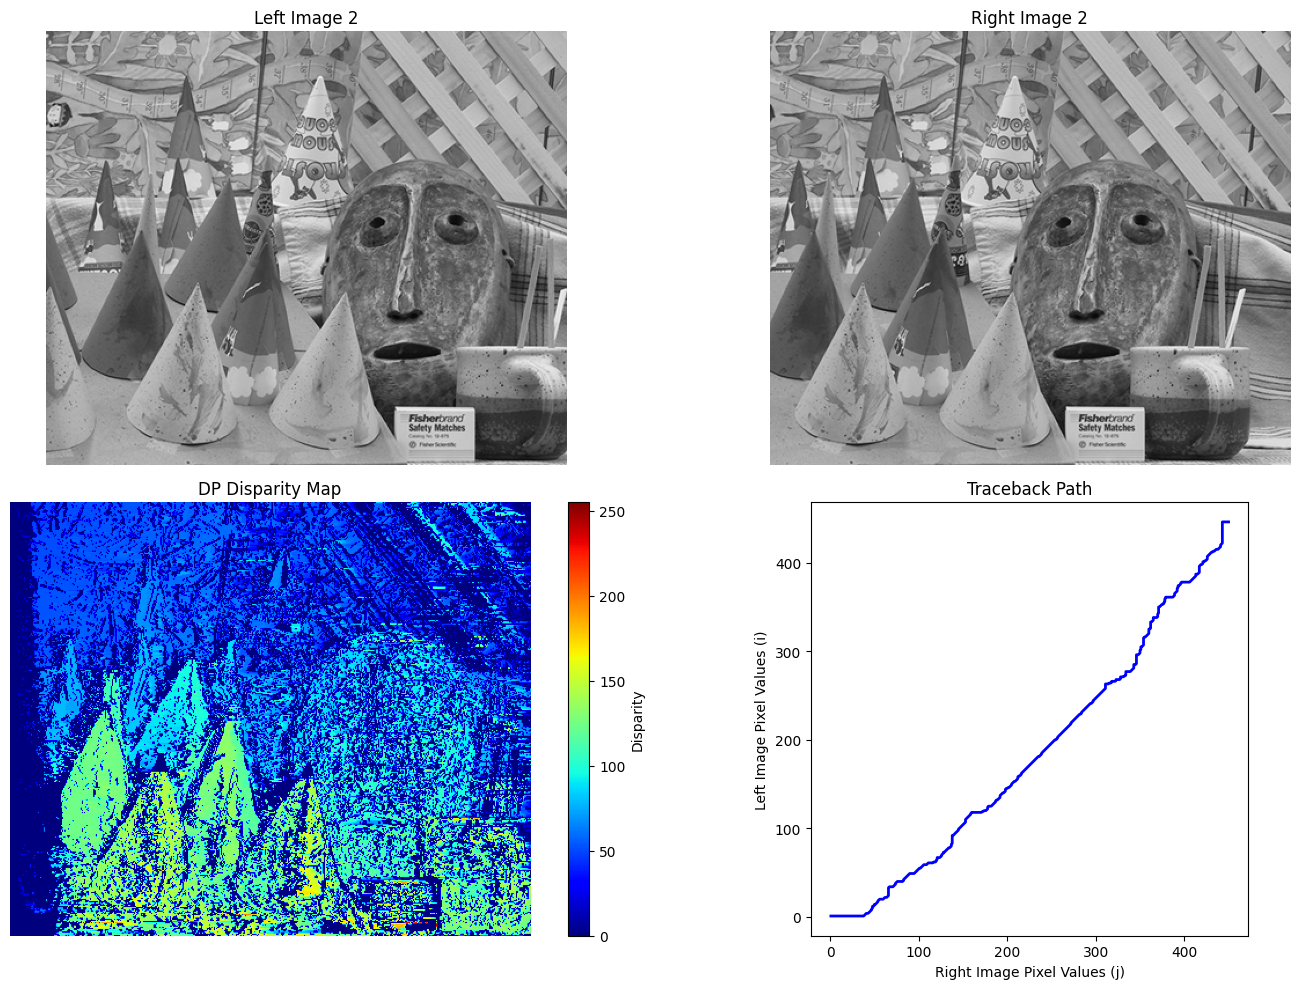

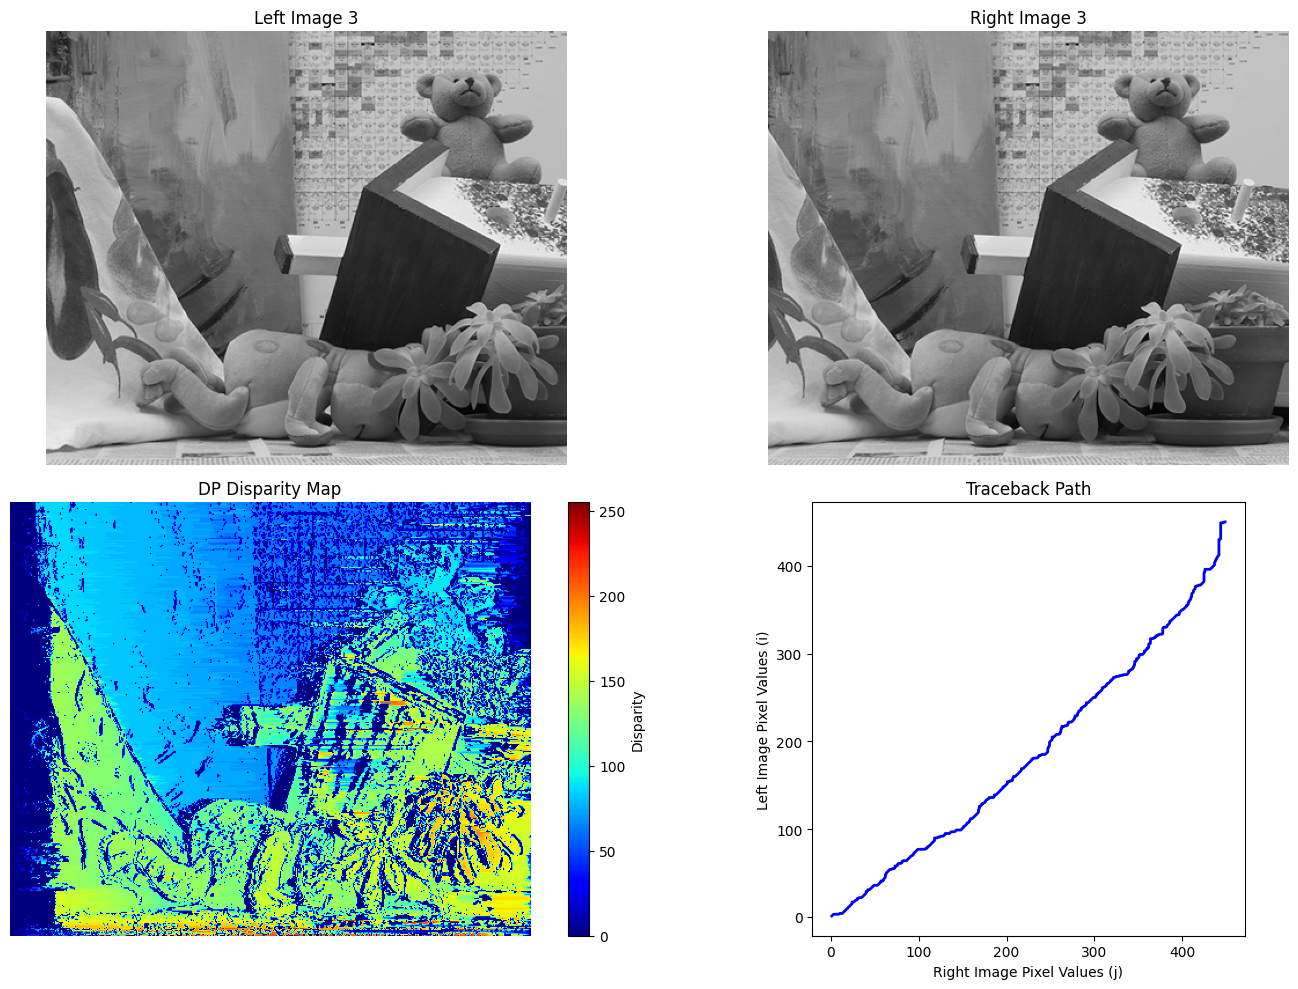

In [30]:

folder_path = "images"  # Replace with the path to your image folder
process_images(folder_path)
